In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
datapath = '/content/drive/MyDrive/training_2'

In [14]:
! pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torchvision
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

     |████████████████████████████████| 584 kB 4.9 MB/s 
     |████████████████████████████████| 221 kB 26.1 MB/s 


In [5]:
!nvidia-smi

Mon Sep  5 10:08:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import time
import torch
import nibabel as nib
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset, PersistentDataset, SmartCacheDataset
from monai.apps import DecathlonDataset
from monai.transforms import (
    MapTransform,
)

print_config()

MONAI version: 0.6.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.1+cu113
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [7]:
!pip install monai nibabel
import torch
import monai
import numpy as np
import matplotlib.pyplot as plt
import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Loading and visualizing ACDC data**

In [18]:
#image = nib.load(datapath +'/patient001/patient001_frame01.nii' ).get_fdata() 
#label = nib.load(datapath +'/patient001/patient001_frame01_gt.nii' ).get_fdata() 

In [56]:
transform = monai.transforms.LoadImageD(("image", "label")) 
file_dict = {"image": "/content/drive/MyDrive/training_2/patient001/patient001_frame01.nii".format(datapath), 
             "label": "/content/drive/MyDrive/training_2/patient001/patient001_frame01_gt.nii".format(datapath)}

data_dict = transform(file_dict)

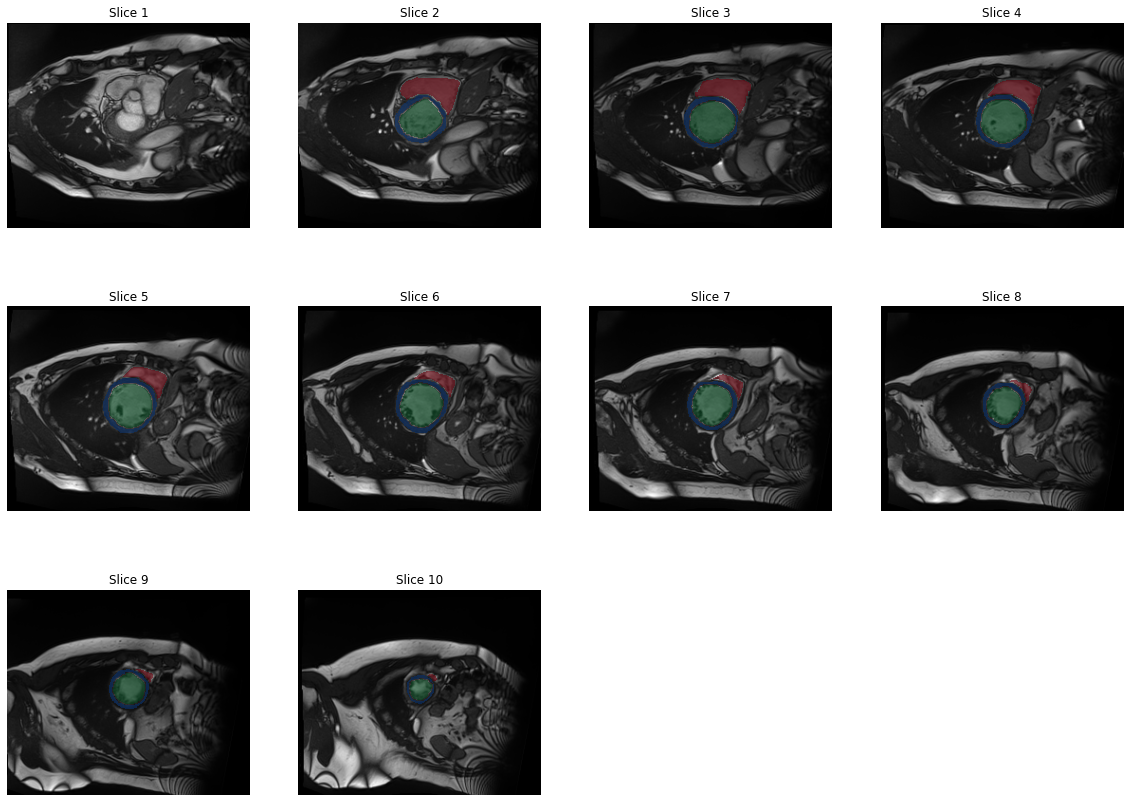

In [57]:
def visualize_data(pt_dict, batch=False):
    image = pt_dict["image"].squeeze()
    label = pt_dict["label"].squeeze()
    if batch:
        image = image.permute((1, 2, 0))
        label = label.permute((1, 2, 0))
    plt.figure(figsize=(20,20))
    for z in range(image.shape[2]): 
      plt.subplot(np.ceil(np.sqrt(image.shape[2])), np.ceil(np.sqrt(image.shape[2])), 1 + z)
      plt.imshow(image[:, :, z], cmap='gray')
      plt.axis('off')
      plt.imshow(np.ma.masked_where(label[:, :, z]!=2, label[:, :, z]==2), alpha=0.6, cmap='Blues', clim=(0, 1))  
      plt.imshow(np.ma.masked_where(label[:, :, z]!=3, label[:, :, z]==3), alpha=0.6, cmap='Greens', clim=(0, 1))
      plt.imshow(np.ma.masked_where(label[:, :, z]!=1, label[:, :, z]==1), alpha=0.6, cmap='Reds', clim=(0, 1))
      plt.title('Slice {}'.format(z + 1))
    plt.show()
    
visualize_data(data_dict)

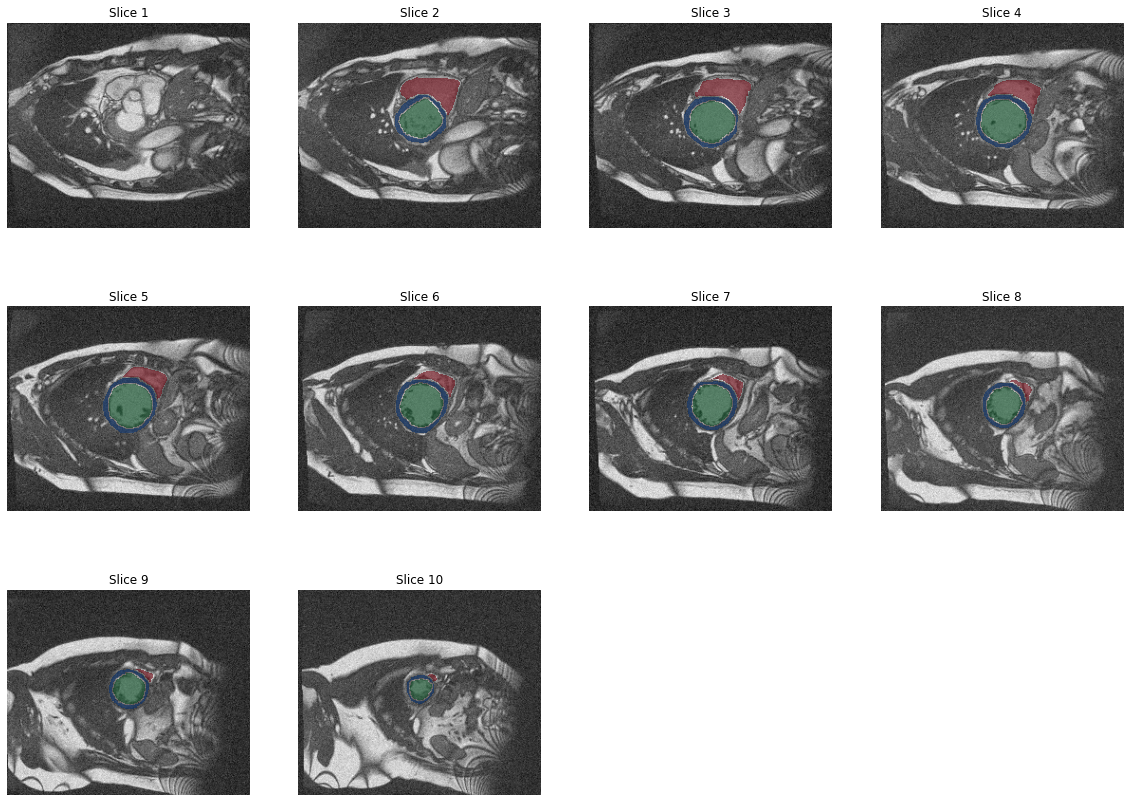

In [58]:
transform = monai.transforms.Compose([monai.transforms.LoadImageD(("image", "label")), 
                                      monai.transforms.ScaleIntensityRangePercentilesd(keys=("image"), lower=5, upper=95, b_min=0, b_max=1, clip=True),
                                      monai.transforms.RandGaussianNoised(("image"), prob=1, std=.3)])

data_dict = transform(file_dict)
visualize_data(data_dict)

In [59]:
file_dict = []
for ptid in range(1, 101):
    gt_filenames = glob.glob(r'{}/patient{}/*_gt.nii.gz'.format(datapath, str(ptid).zfill(3)))
    file_dict.append({'image': gt_filenames[0].replace('_gt', ''), 'label': gt_filenames[0]})
    file_dict.append({'image': gt_filenames[1].replace('_gt', ''), 'label': gt_filenames[1]})
    
transform = monai.transforms.Compose([
    monai.transforms.LoadImageD(("image", "label")),
    monai.transforms.AddChannelD(("image", "label")),
    monai.transforms.ScaleIntensityRangePercentilesd(keys=("image"), lower=5, upper=95, b_min=0, b_max=1, clip=True),
    monai.transforms.RandSpatialCropD(keys=("image", "label"), roi_size=(128, 128, 1), random_center=True, random_size=False),
    monai.transforms.SqueezeDimd(keys=("image", "label"), dim=-1),
    monai.transforms.ToTensorD(("image", "label"))        
])    
    
dataset = monai.data.Dataset(data = file_dict, transform = transform)

IndexError: ignored

In [ ]:
dataloader = monai.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [ ]:
print('The dataset contains {} images'.format(len(dataset)))

visualize_data(next(iter(dataloader)), batch=True)

In [ ]:
val_ids = set(range(1, 101, 5))
train_ids = set(range(1, 101)) - val_ids

In [ ]:
file_dict_train = []
for ptid in train_ids:
    gt_filenames = glob.glob(r'{}/patient{}/*_gt.nii.gz'.format(datapath, str(ptid).zfill(3)))
    file_dict_train.append({'image': gt_filenames[0].replace('_gt', ''), 'label': gt_filenames[0]})
    file_dict_train.append({'image': gt_filenames[1].replace('_gt', ''), 'label': gt_filenames[1]})
    
file_dict_val = []
for ptid in val_ids:
    gt_filenames = glob.glob(r'{}/patient{}/*_gt.nii.gz'.format(datapath, str(ptid).zfill(3)))
    file_dict_val.append({'image': gt_filenames[0].replace('_gt', ''), 'label': gt_filenames[0]})
    file_dict_val.append({'image': gt_filenames[1].replace('_gt', ''), 'label': gt_filenames[1]})    
       
# This transform should be altered to add data augmentation        
transform_train = monai.transforms.Compose([
    monai.transforms.LoadImageD(("image", "label")),
    monai.transforms.AddChannelD(("image", "label")),
    monai.transforms.ScaleIntensityRangePercentilesd(keys=("image"), lower=5, upper=95, b_min=0, b_max=1, clip=True),
    monai.transforms.RandSpatialCropD(keys=("image", "label"), roi_size=(128, 128, 1), random_center=True, random_size=False),
    monai.transforms.SqueezeDimd(keys=("image", "label"), dim=-1),    
    monai.transforms.ToTensorD(("image", "label")),
])

transform_val = monai.transforms.Compose([
    monai.transforms.LoadImageD(("image", "label")),
    monai.transforms.AddChannelD(("image", "label")),
    monai.transforms.ScaleIntensityRangePercentilesd(keys=("image"), lower=5, upper=95, b_min=0, b_max=1, clip=True),
    monai.transforms.ToTensorD(("image", "label")),
])
        
dataset_train = monai.data.CacheDataset(data = file_dict_train, transform = transform_train, progress=False)
dataset_val = monai.data.Dataset(data = file_dict_val, transform = transform_val)

dataloader_train = monai.data.DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
dataloader_val = monai.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

print('The training set contains {} MRI scans.'.format(len(dataset_train)))
print('The test set contains {} MRI scans.'.format(len(dataset_val)))

In [ ]:
visualize_data(next(iter(dataloader_train)), batch=True)
visualize_data(next(iter(dataloader_val)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

In [ ]:
loss_function =  monai.losses.DiceLoss(softmax=True, to_onehot_y=True, batch=True)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:

from tqdm.notebook import tqdm

training_losses = list()

for epoch in tqdm(range(500)):
    model.train()    
    epoch_loss = 0
    step = 0
    for batch_data in dataloader_train: 
        step += 1
        optimizer.zero_grad()
        outputs = model(batch_data["image"].to(device))
        loss = loss_function(outputs, batch_data["label"].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    training_losses.append(epoch_loss/step)

# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')        

In [ ]:
plt.figure()
plt.plot(np.asarray(training_losses))
plt.xlabel('Epoch')
plt.ylabel('Dice loss')
plt.show()
plt.draw()

In [ ]:
model.eval()
postprocess = monai.transforms.Compose([
    monai.transforms.AsDiscrete(argmax=True, to_onehot=True, n_classes=4, threshold_values=False),
    monai.transforms.KeepLargestConnectedComponent(applied_labels=(1, 2, 3), independent=False, connectivity=None)
])

for val_batch in dataloader_val:
    outputs_val = monai.inferers.sliding_window_inference(val_batch["image"].squeeze(1).permute(3, 0, 1, 2).to(device), (128, 128), 32, model, overlap = 0.8)
    outputs_val = outputs_val.permute(1, 2, 3, 0).unsqueeze(0)
    print(outputs_val.shape)
    outputs_val = postprocess(outputs_val)
    result = {"image": val_batch["image"].squeeze(), 
              "label": torch.argmax(outputs_val, dim=1).squeeze().cpu()}
    visualize_data(result)     
    
    dice_metric = monai.metrics.DiceMetric()
    dsc, _ = dice_metric(outputs_val.cpu(), monai.networks.utils.one_hot(val_batch["label"].squeeze().unsqueeze(0).unsqueeze(0), 4))
    hd_metric = monai.metrics.HausdorffDistanceMetric()
    hd, _ = hd_metric(outputs_val.cpu(), monai.networks.utils.one_hot(val_batch["label"].squeeze().unsqueeze(0).unsqueeze(0), 4))
    
    print('Average DSC {:.2f}, average Hausdorff distance {:.2f} mm'.format(dsc[0], hd[0]))
    

In [ ]:
model.load_state_dict(torch.load(r'trainedUNet.pt'))